gaussian
linear
periodic


C:\Users\sy\AppData\Local\Temp\ipykernel_16980\508552406.py:73: RuntimeWarning: covariance is not positive-semidefinite.
  return mvnrand (np.zeros(N), K)


exponential
matern3
matern5


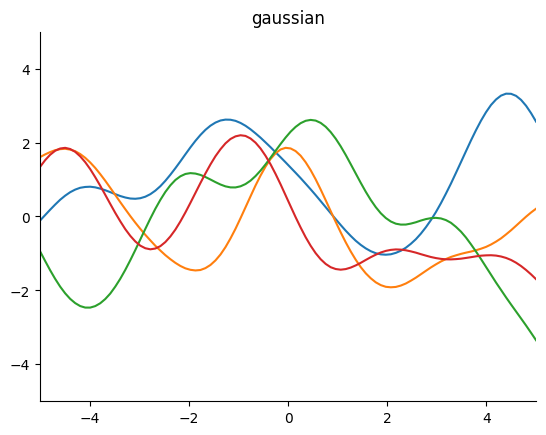

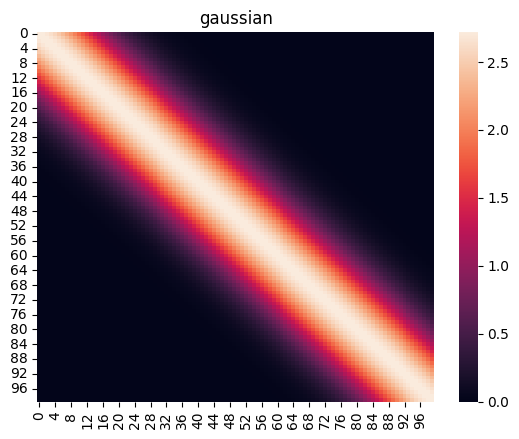

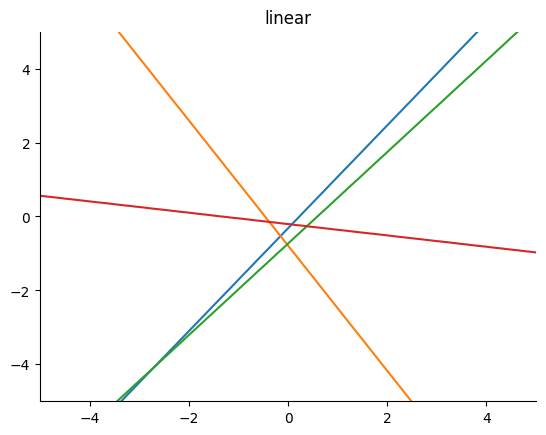

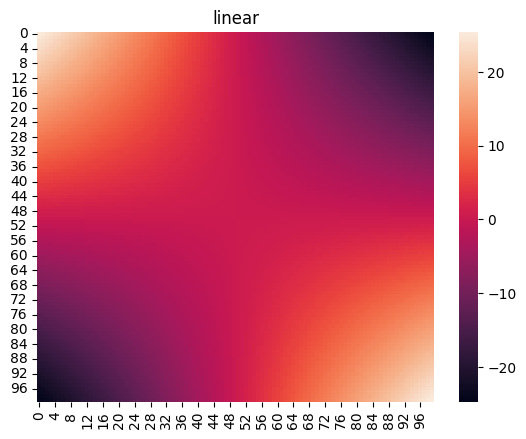

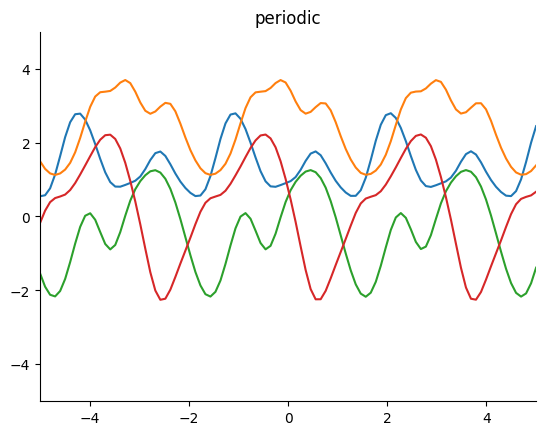

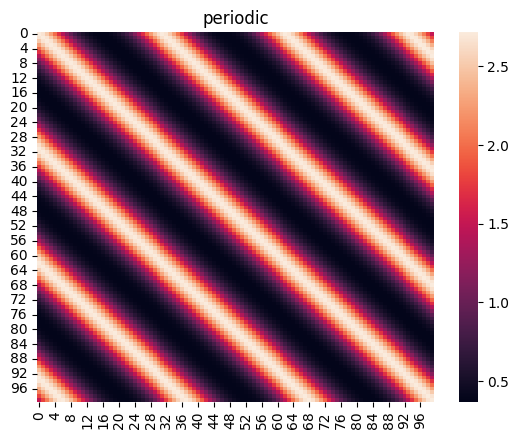

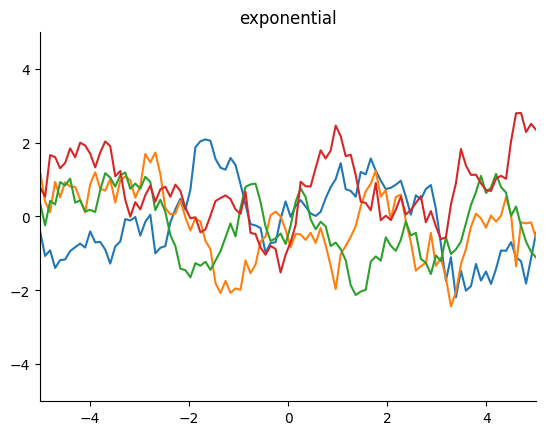

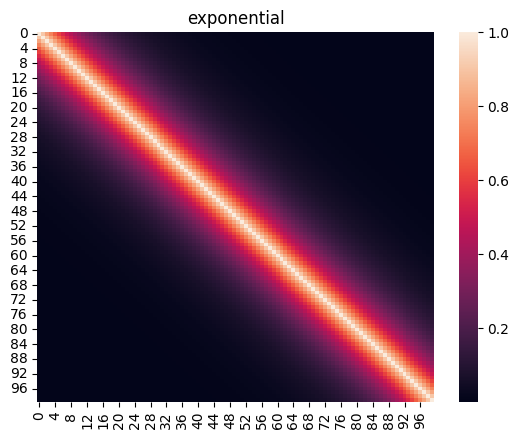

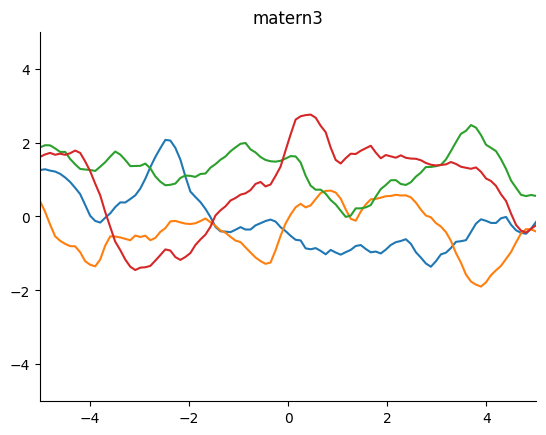

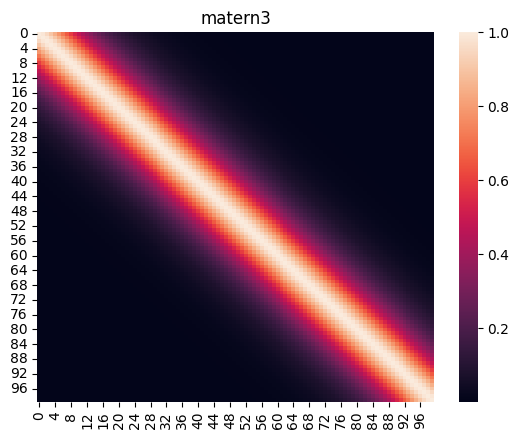

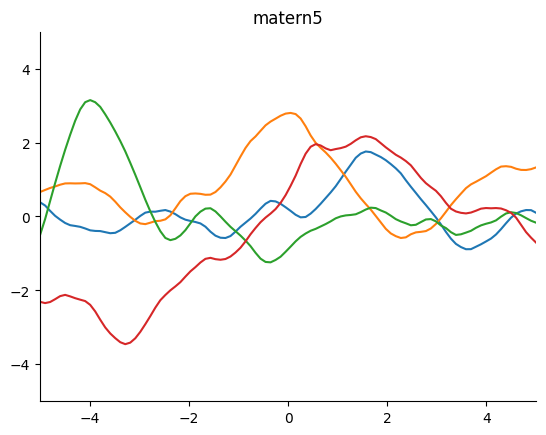

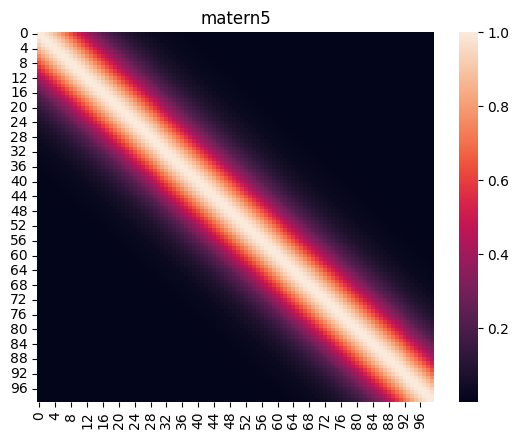

In [1]:
# Fig. 3.11 kernel.py

import library.putil as putil
import numpy as np
from numpy.random import multivariate_normal as mvnrand
import matplotlib.pyplot as plt
import seaborn as sns

xmax = 5
xmin = -5
ymax = 5
ymin = -5
M    = 4
N    = 100

SAVE_FILE = ""

def let (val, func):
    return func(val)

# (3.37), (P.75)
def klinear ():
    # Usually, x should be (b, x) = (b, x1, x2, ..., xn)
    b = np.random.randn()
    return lambda x,y: b + x * y

# (3.38)
def kexp (sigma = 1.0):
    return lambda x,y: np.exp (- np.abs(x - y) / sigma)

# (3.26)
def kgauss (params = (1.0, 1.0)):
    [tau,sigma] = params
    # theta 1 = exp(tau), theta 2 = exp(sigma)
    return lambda x,y: np.exp(tau) * np.exp (-(x - y)**2 / np.exp(sigma))

# (3.39)
def kperiodic (params = (1.0, 0.5)):
    [tau,sigma] = params
    # theta 1 = tau, theta 2 = sigma
    return lambda x,y: np.exp (tau * np.cos ((x - y) / sigma))
#    return lambda x,y: np.exp (tau * np.cos (np.abs(x - y) / sigma))

def kmatern3 (sigma = 1.0):
    # (3.51). nu is 3/2, refer (3.50) for r
    # theta is sigma
    return lambda x,y: \
        let (abs(x - y), lambda r:
             (1 + np.sqrt(3) * r / sigma) * np.exp (- np.sqrt(3) * r / sigma))

def kmatern5 (sigma = 1.0):
    # (3.51). nu is 3/2, refer (3.50) for r
    # theta is sigma
    return lambda x,y: \
        let (abs(x - y), lambda r:
             (1 + np.sqrt(5) * r / sigma + 5 * r * r / (3 * sigma * sigma))
             * np.exp (- np.sqrt(5) * r / sigma))

def kernel_matrix (xx, kernel):
    N = len(xx)
    eta = 1e-6
    # Return K
    # small offset for stability
    # Also refer to (3.58)
    return np.array (
        [kernel (xi, xj) for xi in xx for xj in xx]
    ).reshape(N,N) + eta * np.eye(N)

def fgp (xx, kernel):
    N = len(xx)
    K = kernel_matrix (xx, kernel)
    # Draw all data at the same time
    return mvnrand (np.zeros(N), K)

def fgpGetK(xx, kernel):
    K = kernel_matrix (xx, kernel)

    return K

def plotKernel(kernelName, kernelFunc):
    xx = np.linspace (xmin, xmax, N)

    fig = plt.figure()
    ax = fig.add_subplot()

    print(kernelName)
    for m in range(M):
        plt.plot (xx, fgp (xx, kernelFunc()))

    putil.simpleaxis ()

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(kernelName)

    fig = plt.figure()
    ax = fig.add_subplot()
    sns.heatmap(fgpGetK (xx, kernelFunc()))
    ax.set_title(kernelName)

#    if kernelName == 'periodic':
#        K = fgpGetK (xx, kernelFunc())
#        print(K)
#        print(np.linalg.eig(K))

def main ():
    kernelName = ['gaussian', 'linear', 'periodic', 'exponential', 'matern3', 'matern5']
    kernelFunc = [kgauss, klinear, kperiodic, kexp, kmatern3, kmatern5]

    for kName, kFunc in zip(kernelName, kernelFunc):
        plotKernel(kName, kFunc)

    if len(SAVE_FILE) > 0:
        putil.savefig (SAVE_FILE)
    plt.show ()

if __name__ == "__main__":
    main ()

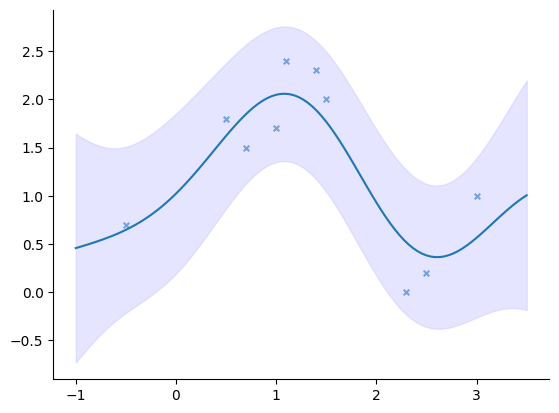

In [2]:
# Fig. 3.16 gpr-simple.py
import library.putil as putil
import numpy as np
from numpy import exp,sqrt
from numpy.linalg import inv
import matplotlib.pyplot as plt

DATA_FILE = "data/gpr.dat"
SAVE_FILE = ""

# plot parameters
N    = 100
xmin = -1
xmax = 3.5
ymin = -1
ymax = 3

# GP kernel parameters
# (3.59)
# If eta is small, y* fits all points. spr will be small. 
eta   = 0.1
#eta   = 1e-6
tau   = 1
sigma = 1

blue = '#ccccff'

# (3.26)
def kgauss (params = (1.0, 1.0)):
    [tau,sigma] = params
    return lambda x,y: tau * exp (-(x - y)**2 / (2 * sigma * sigma))

# (3.68)
def kv (x, xtrain, kernel):
    return np.array ([kernel(x,xi) for xi in xtrain])

# (3.15), (3.63)
def kernel_matrix (xx, kernel):
    N = len(xx)
    
    # (3.59)
    return np.array (
        [kernel (xi, xj) for xi in xx for xj in xx]
    ).reshape(N,N) + eta * np.eye(N)

def gpr (xx, xtrain, ytrain, kernel):
    # Calculate (3.74)
    # K does not depend on x
    # The dimension of K is the dimension of x X the dimension of x
    K = kernel_matrix (xtrain, kernel)
    #print(xtrain)
    #print(K)

    Kinv = inv(K)
    ypr = []
    spr = []
    
    # Calculate y* and its distribution for all xs.
    for x in xx:
        # (3.69) ((3.59))
        s = kernel (x,x) + eta
        # (3.68)
        k = kv (x, xtrain, kernel)
        # Here is (3.75)
        ypr.append (k.T.dot(Kinv).dot(ytrain))
        # (3.74)
        spr.append (s - k.T.dot(Kinv).dot(k))
    return ypr, spr

def gpplot (xx, xtrain, ytrain, kernel, params):
    ypr,spr = gpr (xx, xtrain, ytrain, kernel(params))
#    ax = plt.figure().gca().axes
#    ax.set_ylim(0, 3)
    plt.scatter(xtrain, ytrain, marker = 'x', s = 16)
    plt.plot (xx, ypr)
    plt.fill_between (xx, ypr - 2*sqrt(spr), ypr + 2*sqrt(spr), color = blue, alpha = 0.5)

def main ():
    train = np.loadtxt (DATA_FILE, dtype=float)
        
    xtrain = train.T[0]
    ytrain = train.T[1]
    kernel = kgauss
    params = [tau,sigma]
    xx     = np.linspace (xmin, xmax, N)

    gpplot (xx, xtrain, ytrain, kernel, params)
    
    putil.simpleaxis ()
    if len(SAVE_FILE) > 0:
        putil.savefig (SAVE_FILE)
    
    plt.show ()

if __name__ == "__main__":
    main ()


converged - relative reduction in objective
params =
[ 0.42157265 -0.37202748 -2.70259141]


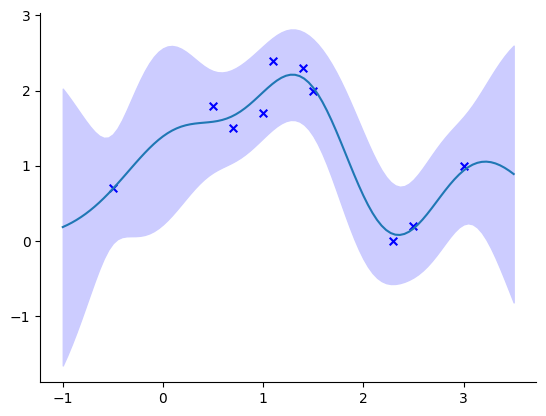

In [3]:

# Fig. 3.20 gpr.py

#from pylab import *
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import det, inv
# To use this, install Gpy with "pip install GPy"
from paramz.optimization.scg import SCG
from scipy.optimize import fmin_l_bfgs_b, minimize

import library.putil as putil

DATA_FILE = "data/gpr.dat"
SAVE_FILE = ""

# plot parameters
N    = 100
xmin = -1
xmax = 3.5
ymin = -1
ymax = 3
blue = '#ccccff'

# (3.26). For +exp(eta), refer to (3.96)((3.87), and (3.59))
# 対角の要素だと、x=yになるが、対角でなくてもx=yになる可能性があるのでは??
def kgauss (params):
    [tau,sigma,eta] = params
    return lambda x,y,train=True: \
        exp(tau) * exp (-(x - y)**2 / exp(sigma)) + (exp(eta) if (train and x == y) else 0)

def kgauss_grad (xi,xj,d,kernel,params):
    # refer P.91

    # d == 0 => tau (dk / d tau)
    if d == 0:
        #return exp(params[d]) * kernel(params)(xi, xj)
        return exp(params[d]) * kernel(params)(xi, xj, train = False)
    # d == 1 => sigma (dk / d sigma)
    if d == 1:
        #return kernel(params)(xi, xj) * (xi - xj) * (xi - xj) / exp(params[d])
        return kernel(params)(xi, xj, train = False) * (xi - xj) * (xi - xj) / exp(params[d])
    # d == 2 => eta (dk / d eta)
    if d == 2:
        return (exp(params[d]) if xi == xj else 0)
    else:
        return 0
    
def kv (x, xtrain, kernel):
    # For k*
    return np.array ([kernel(x,xi,False) for xi in xtrain])

def kernel_matrix (xx, kernel):
    # For K_theta
    N = len(xx)
    return np.array (
        [kernel (xi, xj) for xi in xx for xj in xx]
    ).reshape(N,N)

def gpr (xx, xtrain, ytrain, kernel):
    # (3.82)
    K = kernel_matrix (xtrain, kernel)
    Kinv = inv(K)
    ypr = []
    spr = []
    for x in xx:
        # k** (3.69) for each x
        s = kernel (x,x)
        # k* (3.68) for each x
        k = kv (x, xtrain, kernel)
        # (3.74)
        ypr.append (k.T.dot(Kinv).dot(ytrain))
        # (3.74)
        spr.append (s - k.T.dot(Kinv).dot(k))
    return ypr, spr

def tr(A,B):
    # * means Hadamard product.
    # This is the same result with np.trace(A.dot(B))
    return (A*B.T).sum()

def printparam (params):
    print (params)

def loglik (params,xtrain,ytrain,kernel,kgrad):
    K = kernel_matrix (xtrain, kernel(params))
    Kinv = inv(K)
    # (3.92)
    # maximize this value
    return np.log(det(K)) + ytrain.T.dot(Kinv).dot(ytrain)
    # (3.91)
    # return (N * log(2*np.pi) + \
    #         log(det(K)) + ytrain.T.dot(Kinv).dot(ytrain)) / 2

def gradient (params,xtrain,ytrain,kernel,kgrad):
    K = kernel_matrix (xtrain, kernel(params))
    Kinv = inv(K)
    Kinvy = Kinv.dot(ytrain)
    D = len(params)
    # This N is different from global N.
    N = len(xtrain)
    grad = np.zeros(D)
    for d in range(D):
        G = np.array (
                [kgrad (xi, xj, d, kernel, params)
                for xi in xtrain for xj in xtrain]
            ).reshape(N,N)
        # grad for each parameter
        grad[d] = tr(Kinv,G) - Kinvy.dot(G).dot(Kinvy)
    return grad

# Optimization with BFGS.
def optimize (xtrain, ytrain, kernel, kgrad, init):
    res = minimize (loglik, init, args = (xtrain,ytrain,kernel,kgrad),
                    jac = gradient,
                    method = 'BFGS', callback = printparam,
                    options = {'gtol' : 1e-4, 'disp' : True})
    print(res.message)
    return res.x

# Optimization with SCG.
def optimize1 (xtrain, ytrain, kernel, kgrad, init):
    x,flog,feval,status = SCG (loglik, gradient, init,
                               optargs=[xtrain,ytrain,kernel,kgrad])
    print(status)
    return x

# Optimization with L_BFGS_B.
def optimize2 (xtrain, ytrain, kernel, kgrad, init):
    x,f,d = fmin_l_bfgs_b (loglik, init, fprime=gradient,
                           args=[xtrain,ytrain,kernel,kgrad],
                           iprint=0, maxiter=1000)
    print (d)
    return x

def gpplot (xtrain, ytrain, kernel, params):
    xx = np.linspace (xmin, xmax, N)
    ypr,spr = gpr (xx, xtrain, ytrain, kernel(params))
    plt.plot (xx, ypr)
    plt.fill_between (xx, ypr - 2*sqrt(spr), ypr + 2*sqrt(spr), color=blue)
    plt.scatter (xtrain, ytrain, marker = 'x', s = 30, c = "blue")

def main ():
    # load data
    train = np.loadtxt (DATA_FILE, dtype=float)
    xtrain = train.T[0]
    ytrain = train.T[1]

    # initialize parameters
    # kernel parameters
    tau   = np.log(1)
    sigma = np.log(1)
    eta   = np.log(1)
    params = np.array ([tau, sigma, eta])
        
    kernel = kgauss
    kgrad  = kgauss_grad

    # print 'grad  =', gradient (params, xtrain, ytrain, kernel, kgrad)

    # Get the parameters which maximize log-likelihood

    # BFSG     
    #params = optimize (xtrain, ytrain, kernel, kgrad, params)
    # SCG
    params = optimize1 (xtrain, ytrain, kernel, kgrad, params)
    # L_BFSG_B
    #params = optimize2 (xtrain, ytrain, kernel, kgrad, params)

    print ('params =')
    print (params)

    # Using the parameter, plot predicted Ys(average) and their variance
    gpplot (xtrain, ytrain, kernel, params)
    putil.simpleaxis ()
    
    if len(SAVE_FILE) > 2:
        putil.savefig (SAVE_FILE)
    plt.show ()

if __name__ == "__main__":
    main ()

[iter  1]
-151.10470193504395
[iter  2]
-106.01953105136232
[iter  3]
-104.74015673708466
[iter  4]
-104.58792437911677
[iter  5]
-104.56265580413664
[iter  6]
-103.10199496957264
[iter  7]
-103.2075471521105
[iter  8]
-102.5809210930795
[iter  9]
-99.66925045425805
[iter 10]
-97.9828557443749



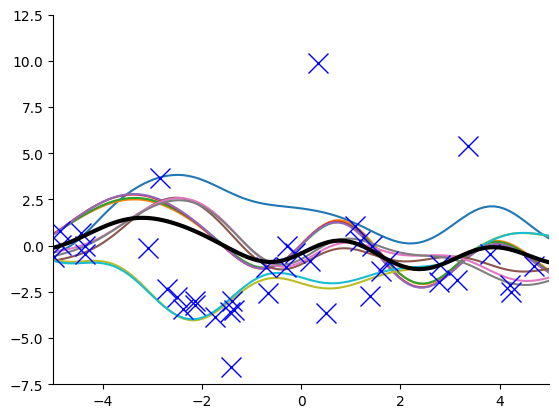

In [4]:
# Fig 3.25(b) gpr-cauchy.py
import sys
import library.putil as putil
import numpy as np
#from pylab import *
from numpy import exp,log
#from elliptical import elliptical
from numpy.linalg import cholesky as chol
import matplotlib.pyplot as plt

DATA_FILE = "data/gpr-cauchy.dat"
ITERS = 10
SAVE_FILE = ""

# ellipical.py

#  Elliptical slice sampling.
#  $Id: elliptical.py,v 1.1 2018/02/27 03:23:39 daichi Exp $
#  based on the code of Iain Murray
#  http://homepages.inf.ed.ac.uk/imurray2/pub/10ess/elliptical_slice.m
#
#  xx     : Dx1 initial vector
#  prior  : DxD matrix from chol(S)
#  likfun : function of likelihood evaluation
#  params : parameters passed to likfun (optional)
#  curlik : current likelihood (possibly from previous iteration)
#  angle  : default 0

# refer Fig. 7.15
def elliptical (xx,prior,likfun,params=(),curlik=None,angle=0):
    # initialize
    D = len(xx)
    if curlik is None:
        curlik = likfun (xx, params)

    # set up the ellipse

    # refer P.49
    # step 3
    nu = np.dot (prior, np.random.randn(D))
    # likfun returns log-likelihood
    # step 2
    # (7.50)
    hh = np.log (np.random.rand()) + curlik
    # set up the bracket
    if angle <= 0:
        # step 4
        phi = np.random.rand() * 2 * np.pi
        # step 5
        min_phi = phi - 2 * np.pi
        max_phi = phi
    else:
        min_phi = - angle * np.random.rand()
        max_phi = min_phi + angle
        phi = min_phi + np.random.rand() * (max_phi - min_phi)
        
    # slice sampling loop
    # step 6
    while True:
        # step 7
        # (7.50)
        prop = xx * np.cos(phi) + nu * np.sin(phi)
        # calculation of L(f)(likfun(prop))
        curlik = likfun (prop, params)
        # step 8
        if curlik > hh:
            # (step 9)
            break
        # step 10
        if phi > 0:
            # step 11
            max_phi = phi
        elif phi < 0:
            # step 11
            min_phi = phi
        else:
            raise IOError('BUG: slice sampling shrunk to the current position.')
        # step 12
        phi = min_phi + np.random.rand() * (max_phi - min_phi)
        
    # step 9
    return (prop,curlik)
                           
# end of ellipical.py

def gpr_cauchy (f,param):
    x,y,gamma,Kinv = param
    M = len(x)
    return gpr_cauchy_lik (y[0:M], f[0:M], gamma, Kinv)

# log of (3.104)
# constant is ignored
def gpr_cauchy_lik (y, f, gamma, Kinv):
    return - np.sum (log (gamma + (y - f)**2 / gamma)) \
           - np.dot (f, np.dot(Kinv, f)) / 2

# this function has been used
# (3.26)
def kgauss (tau,sigma):
    return lambda x,y: exp(tau) * exp (-(x - y)**2 / exp(sigma))

# this function has been used
# (3.59)
def kernel_matrix (xx, kernel):
    N = len(xx)
    eta = 1e-6
    return np.array (
        [kernel (xi, xj) for xi in xx for xj in xx]
    ).reshape(N,N) + eta * np.eye(N)

def gpr_mcmc (x,y,iters,xmin,xmax,gamma):
    xx = np.hstack((x,np.linspace(xmin,xmax,100)))
    M = len(x)
    N = len(xx)
    # This K is similar to K in (3.76)
    K = kernel_matrix (xx, kgauss(1,1))
    # This Kinv is not K^{-1}
    Kinv = np.linalg.inv(K[0:M,0:M])
    S = chol (K)
    # sample f.
    # p(f) is shown in (3.103)
    f = np.dot (S, np.random.randn(N))
    g = np.zeros (len(xx))
    for iter in range(iters):
        # update f using sampling
        # lik may sometimes get smaller.
        # But lik should get larger.
        f,lik = elliptical (f, S, gpr_cauchy, (x,y,gamma,Kinv))
        g = g + f
        print('\r[iter %2d]' % (iter + 1))
        print(lik)
        plt.plot (xx[M:],f[M:])  # color='gray')
    print('')
    plt.plot (x,y,'bx',markersize=14)
    # plot average of samples
    plt.plot (xx[M:],g[M:]/iters,'k',linewidth=3)
    putil.simpleaxis ()

def main ():
    xmin = -5
    xmax =  5
    ymin = -7.5
    ymax = 12.5
    gamma = 0.2
    
    [x,y,f] = np.loadtxt (DATA_FILE).T
    iters = ITERS

    gpr_mcmc (x,y,iters,xmin,xmax,gamma)
    plt.axis ([xmin,xmax,ymin,ymax])
    
    if len(SAVE_FILE) > 0:
        putil.savefig (sys.argv[3])
    plt.show ()

if __name__ == "__main__":
    main ()


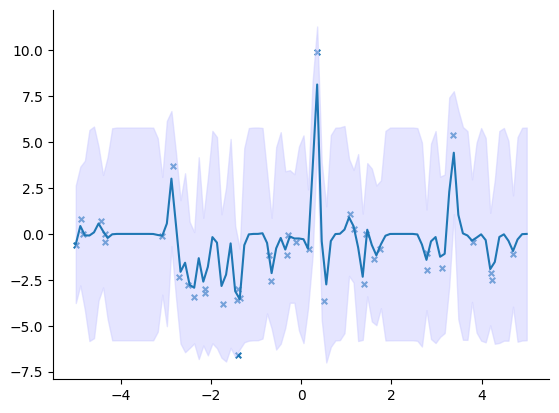

In [5]:
# Fig. 3.25(a)
# Refer to Fig. 3.16

import library.putil as putil
import numpy as np
from numpy import exp,sqrt
from numpy.linalg import inv
import matplotlib.pyplot as plt

DATA_FILE = "data/gpr-cauchy.dat"
SAVE_FILE = ""

# plot parameters
N    = 100
# change for Fig 3.25(a)
xmin = -5.0
xmax = 5.0
ymin = -7.5
ymax = 12.5

# change for Fig 3.25(a)
tau   = 7.17
sigma = 0.01
eta   = 1.22

blue = '#ccccff'

# change for Fig 3.25(a) 
def kspecial (params = (7.17, 0.01)):
    [tau,sigma] = params
    return lambda x,y: tau * exp (-(x - y)**2 / sigma)

# (3.68)
def kv (x, xtrain, kernel):
    return np.array ([kernel(x,xi) for xi in xtrain])

# (3.15), (3.63)
def kernel_matrix (xx, kernel):
    N = len(xx)
    
    # (3.59)
    return np.array (
        [kernel (xi, xj) for xi in xx for xj in xx]
    ).reshape(N,N) + eta * np.eye(N)

def gpr (xx, xtrain, ytrain, kernel):
    # Calculate (3.74)
    # K does not depend on x
    # The dimension of K is the dimension of x X the dimension of x
    K = kernel_matrix (xtrain, kernel)
    #print(xtrain)
    #print(K)

    Kinv = inv(K)
    ypr = []
    spr = []
    
    # Calculate y* and its distribution for all xs.
    for x in xx:
        # (3.69) ((3.59))
        s = kernel (x,x) + eta
        # (3.68)
        k = kv (x, xtrain, kernel)
        # Here is (3.75)
        ypr.append (k.T.dot(Kinv).dot(ytrain))
        # (3.74)
        spr.append (s - k.T.dot(Kinv).dot(k))
    return ypr, spr

def gpplot (xx, xtrain, ytrain, kernel, params):
    ypr,spr = gpr (xx, xtrain, ytrain, kernel(params))
#    ax = plt.figure().gca().axes
#    ax.set_ylim(0, 3)
    plt.scatter(xtrain, ytrain, marker = 'x', s = 16)
    plt.plot (xx, ypr)
    plt.fill_between (xx, ypr - 2*sqrt(spr), ypr + 2*sqrt(spr), color = blue, alpha = 0.5)

def main ():
    train = np.loadtxt (DATA_FILE, dtype=float)
        
    xtrain = train.T[0]
    ytrain = train.T[1]
    # change for Fig 3.25(a)
    kernel = kspecial

    # change for Fig 3.25(a)
    params = [tau,sigma]
    xx     = np.linspace (xmin, xmax, N)

    gpplot (xx, xtrain, ytrain, kernel, params)
    
    putil.simpleaxis ()
    if len(SAVE_FILE) > 0:
        putil.savefig (SAVE_FILE)
    
    plt.show ()

if __name__ == "__main__":
    main ()


converged - relative reduction in objective
params =
[0.84413417 0.29572487 1.74978615]
[2.32596304 1.3441003  5.75337217]


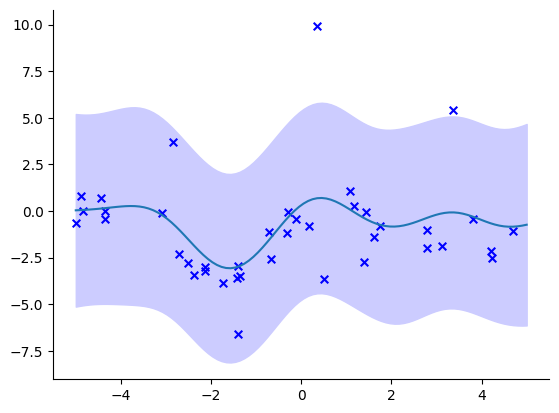

In [6]:
# Fig. 3.25(a) gpr.py
# Refer to Fig. 3.20

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import det, inv
# To use this, install Gpy with "pip install GPy"
from paramz.optimization.scg import SCG
from scipy.optimize import fmin_l_bfgs_b, minimize

import library.putil as putil

# change for Fig 3.25
DATA_FILE = "data/gpr-cauchy.dat"
SAVE_FILE = ""

# plot parameters
N    = 100
# change for Fig 3.25(a)
xmin = -5.0
xmax = 5.0
ymin = -7.5
ymax = 12.5

blue = '#ccccff'

# (3.26). For +exp(eta), refer to (3.96)((3.87), and (3.59))
# 対角の要素だと、x=yになるが、対角でなくてもx=yになる可能性があるのでは??
# this function can be the same with Fig 3.20!
def kgauss (params):
    [tau,sigma,eta] = params
    return lambda x,y,train=True: \
        exp(tau) * exp (-(x - y)**2 / exp(sigma)) + (exp(eta) if (train and x == y) else 0)

# This function is also the same with Fig 3.20
def kgauss_grad (xi,xj,d,kernel,params):
    # refer P.91

    # d == 0 => tau (dk / d tau)
    if d == 0:
        #return exp(params[d]) * kernel(params)(xi, xj)
        return exp(params[d]) * kernel(params)(xi, xj, train = False)
    # d == 1 => sigma (dk / d sigma)
    if d == 1:
        #return kernel(params)(xi, xj) * (xi - xj) * (xi - xj) / exp(params[d])
        return kernel(params)(xi, xj, train = False) * (xi - xj) * (xi - xj) / exp(params[d])
    # d == 2 => eta (dk / d eta)
    if d == 2:
        return (exp(params[d]) if xi == xj else 0)
    else:
        return 0
    
def kv (x, xtrain, kernel):
    # For k*
    return np.array ([kernel(x,xi,False) for xi in xtrain])

def kernel_matrix (xx, kernel):
    # For K_theta
    N = len(xx)
    return np.array (
        [kernel (xi, xj) for xi in xx for xj in xx]
    ).reshape(N,N)

def gpr (xx, xtrain, ytrain, kernel):
    # (3.82)
    K = kernel_matrix (xtrain, kernel)
    Kinv = inv(K)
    ypr = []
    spr = []
    for x in xx:
        # k** (3.69) for each x
        s = kernel (x,x)
        # k* (3.68) for each x
        k = kv (x, xtrain, kernel)
        # (3.74)
        ypr.append (k.T.dot(Kinv).dot(ytrain))
        # (3.74)
        spr.append (s - k.T.dot(Kinv).dot(k))
    return ypr, spr

def tr(A,B):
    # * means Hadamard product.
    # This is the same result with np.trace(A.dot(B))
    return (A*B.T).sum()

def printparam (params):
    print (params)

def loglik (params,xtrain,ytrain,kernel,kgrad):
    K = kernel_matrix (xtrain, kernel(params))
    Kinv = inv(K)
    # (3.92)
    # maximize this value
    return np.log(det(K)) + ytrain.T.dot(Kinv).dot(ytrain)
    # (3.91)
    # return (N * log(2*np.pi) + \
    #         log(det(K)) + ytrain.T.dot(Kinv).dot(ytrain)) / 2

def gradient (params,xtrain,ytrain,kernel,kgrad):
    K = kernel_matrix (xtrain, kernel(params))
    Kinv = inv(K)
    Kinvy = Kinv.dot(ytrain)
    D = len(params)
    # This N is different from global N.
    N = len(xtrain)
    grad = np.zeros(D)
    for d in range(D):
        G = np.array (
                [kgrad (xi, xj, d, kernel, params)
                for xi in xtrain for xj in xtrain]
            ).reshape(N,N)
        # grad for each parameter
        grad[d] = tr(Kinv,G) - Kinvy.dot(G).dot(Kinvy)
    return grad

# Optimization with SCG.
def optimize1 (xtrain, ytrain, kernel, kgrad, init):
    x,flog,feval,status = SCG (loglik, gradient, init,
                               optargs=[xtrain,ytrain,kernel,kgrad])
    print(status)
    return x

def gpplot (xtrain, ytrain, kernel, params):
    xx = np.linspace (xmin, xmax, N)
    ypr,spr = gpr (xx, xtrain, ytrain, kernel(params))
    plt.plot (xx, ypr)
    plt.fill_between (xx, ypr - 2*sqrt(spr), ypr + 2*sqrt(spr), color=blue)
    plt.scatter (xtrain, ytrain, marker = 'x', s = 30, c = "blue")

def main ():
    # load data
    train = np.loadtxt (DATA_FILE, dtype=float)
    xtrain = train.T[0]
    ytrain = train.T[1]

    # initialize parameters
    # kernel parameters
    tau   = np.log(1)
    sigma = np.log(1)
    eta   = np.log(1)
    params = np.array ([tau, sigma, eta])
        
    kernel = kgauss
    kgrad  = kgauss_grad

    # Get the parameters which maximize log-likelihood

    # SCG
    params = optimize1 (xtrain, ytrain, kernel, kgrad, params)

    print ('params =')
    print (params)
    print (np.exp(params))

    # Using the parameter, plot predicted Ys(average) and their variance
    gpplot (xtrain, ytrain, kernel, params)
    putil.simpleaxis ()
    
    if len(SAVE_FILE) > 2:
        putil.savefig (SAVE_FILE)
    plt.show ()

if __name__ == "__main__":
    main ()

# 自由度が増えるのは良いが、ガウスカーネルでもパラメータを適切に選択するとそれなりに結果が良さそう。
# 解析的にできるので、おそらく計算は速いし、計算は安定しそう。

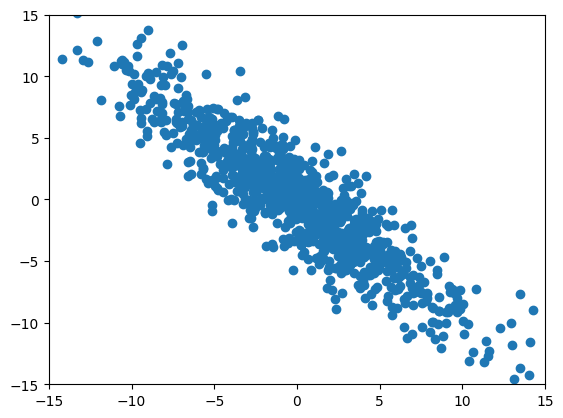

In [7]:
# Fig 3.31(b)

import numpy as np
import matplotlib.pyplot as plt

# H
hiddenNodeNum = 100
sampleNum = 1000
inputData = [-0.2, 0.4]

sigmaW = 5
sigmaV = 5
sigmaB = 0.1
#sigmaW2 = np.sqrt(5)
#sigmaV2 = np.sqrt(5)
#sigmaB2 = np.sqrt(0.1)

xmin = -15.0
xmax = 15.0
ymin = -15.0
ymax = 15.0

inputData = np.array(inputData)

# step.m
# activation function
def stepFunc(x):
    data = (x>=0)
    return 2*data.astype(np.int64) - 1

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def nngp(hiddenNodeNum, inputData, sampleNum = 1000):
    y = []

    # To plot the data, len(inputData) must be 2
    for i in range(len(inputData)):
        y.append([])
    #print(y)

    for i in range(sampleNum):
        # *5 is not necessary required
        # W is the same for x1 and x2.
        # here, x size is D = 1. x_n has N = 2 elements.
        # y_i = sum(v_h * h(x_i)_h)
        # h(x_i)_h = sigma(b_h + w_h * x_i)
        W = np.random.randn(hiddenNodeNum) * sigmaW
        V = np.random.randn(hiddenNodeNum) * sigmaV / np.sqrt(hiddenNodeNum)
        B = np.random.randn(hiddenNodeNum) * sigmaB

        for j in range(len(inputData)):
            h = W * inputData[j] + B
            y[j].append(stepFunc(h).dot(V))
        #    y[j].append(sigmoid(h).dot(V))

    return y
        
def main ():
    y = nngp(hiddenNodeNum, inputData, sampleNum)

    plt.scatter(y[0], y[1])
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    
if __name__ == "__main__":
    main ()